In [58]:
# KI-Gilde
# QAware GmbH, Munich
# 11.3.2021
# revived 17.10.2025

### What is this Exercise about?

Classifiers analyse datasets whose structure we can only guess but are unable to formalize:
We  tell spam easily, but precise rules are hard to come by. Classifiers are trained on a
train dataset and tested on a separate test dataset. The resulting assessment of depends on the quality of the date sets.

In this exercise, we use data sets with a known structure in order to compare different approaches: perceptrons,
neuronal networks with one or two layers and different loss functions.

The data sets are given by boolean functions (AND, OR an XOR), or geometrical objects such as
half-planes, circles, squares or concentric rings.
Each of these functions returns 1 on a subset of $R^2$ (a half-plane, a circle or a square) and 0 on its complement.
On concentric rings, the corresponding function alternates between 1 and 0.

So, `p = plane([0, 1], 0)` defines the lower half-plane in $R^2$; `p(X)` returns 1 iff $X_1 <= 0$.
Likewise, `c = circle(1)` defines a circle with radius 1 around the origin; `c(X)` returns 1
if X is in the circle or on its boundary, else 0.

AND, OR and half-planes are linearly separable, XOR, circles and squares are not.
Let's see how different approaches perform. Concentric rings are particularly difficult.

In [59]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Perceptron as SkPerceptron
from torch import tensor

from classifier_fcts import _and, _xor, _or, plane, circle, square, rings
from classifier_class import Classifier
from perceptron import Perceptron as MyPerceptron
from sandbox.ai.util.metrics import plot_confusion_matrix  #, plot_loss
from sandbox.ai.util.utils import flatten_to_long

# uncomment this on jupyterlab
# import sys
# sys.path.insert(0, '../shared')
# from metrics import plot_confusion_matrix #, plot_loss

### Regressor with one layer, mean square error loss
This is a regressor turned into a classifier by rounding.
Generally not recommended.

In [60]:
def regressor21(lr):
    M = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())
    optimizer = optim.Adam(M.parameters(), lr=lr)
    loss_fct = nn.MSELoss()
    # pred = Y rounded to nearest integer with gradient removed
    pred_fct = lambda Y: torch.round(Y).detach()
    return Classifier(M, optimizer, loss_fct, pred_fct)

### Classifier with one layer, binary cross entropy loss

In [61]:
def classifier21(lr):
    M = nn.Linear(2, 1)
    optimizer = optim.Adam(M.parameters(), lr=lr)
    loss_fct = nn.BCEWithLogitsLoss()
    pred_fct = lambda Y: torch.heaviside(Y, torch.zeros(1))
    return Classifier(M, optimizer, loss_fct, pred_fct)

### Classifier with one layer, cross entropy loss

In [62]:
def classifier22(lr):
    M = nn.Linear(2, 2)
    optimizer = optim.Adam(M.parameters(), lr=lr)
    loss_fct = nn.CrossEntropyLoss()
    # pred = index of max value on each row (always 0 or 1)
    pred_fct = lambda Y: torch.argmax(Y, dim=1).view(-1, 1)
    return Classifier(M, optimizer, loss_fct, pred_fct, flatten_to_long)

### Regressor with two layers, mean square error loss
This is a regressor turned into a classifier by rounding.
Generally not recommended.

In [63]:
def regressor251(lr):
    M = nn.Sequential(nn.Linear(2, 5), nn.Sigmoid(), nn.Linear(5, 1))
    optimizer = optim.Adam(M.parameters(), lr=lr)
    loss_fct = nn.MSELoss()
    # pred = Y rounded to nearest integer with gradient removed
    pred_fct = lambda Y: torch.round(Y).detach()
    return Classifier(M, optimizer, loss_fct, pred_fct)

### Classifiers with two layers, binary cross entropy loss

In [64]:
def classifier251(lr):
    M = nn.Sequential(nn.Linear(2, 5), nn.Sigmoid(), nn.Linear(5, 1))
    optimizer = optim.Adam(M.parameters(), lr=lr)
    loss_fct = nn.BCEWithLogitsLoss()
    pred_fct = lambda Y: torch.heaviside(Y, torch.zeros(1))
    return Classifier(M, optimizer, loss_fct, pred_fct)

###  Classifiers with two layers, cross entropy loss

In [65]:
def classifier252(lr):
    M = nn.Sequential(nn.Linear(2, 5), nn.Sigmoid(), nn.Linear(5, 2))
    optimizer = optim.Adam(M.parameters(), lr=lr)
    loss_fct = nn.CrossEntropyLoss()
    # pred = index of max value on each row (always 0 or 1)
    pred_fct = lambda Y: torch.argmax(Y, dim=1).view(-1, 1)
    return Classifier(M, optimizer, loss_fct, pred_fct, flatten_to_long)

###  Classifiers with three layers, cross entropy loss

In [66]:
def classifier2XX2(lr):
    M = nn.Sequential(nn.Linear(2, 8), nn.Linear(8, 3), nn.ReLU(), nn.Linear(3, 2))
    optimizer = optim.Adagrad(M.parameters(), lr=lr)
    loss_fct = nn.CrossEntropyLoss()
    # pred = index of max value on each row (always 0 or 1)
    pred_fct = lambda Y: torch.argmax(Y, dim=1).view(-1, 1)
    return Classifier(M, optimizer, loss_fct, pred_fct, flatten_to_long)

###  A plot utility
must go here for neat output (??)

In [67]:
def plot_loss(protocol, title='', label=''):
    """
    @param protocol: list of tuples (timestamp, loss)
    @param title: title of graph
    @param label: label of graph
    @return: None
    Plot change of loss over time
    """
    plt.plot(protocol, label=label)
    plt.title(title, fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('loss')
    plt.xlabel('iterations')

### some constants

In [68]:
X_raw = [[0, 0], [0, 1], [1, 0], [1, 1]]
dict = {'AND': _and, 'OR': _or, 'XOR': _xor}
# variants = [regressor21, classifier21, classifier22, regressor251, classifier251, classifier252, classifier2XX2]
variants = [regressor251, classifier251, classifier252, classifier2XX2]

cat_names = ['incorrect', 'correct']


### Testing the self-made perceptron on AND, OR and XOR

<Figure size 2000x1400 with 0 Axes>

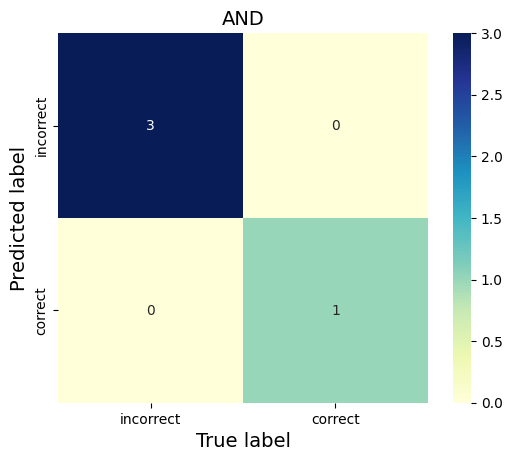

<Figure size 2000x1400 with 0 Axes>

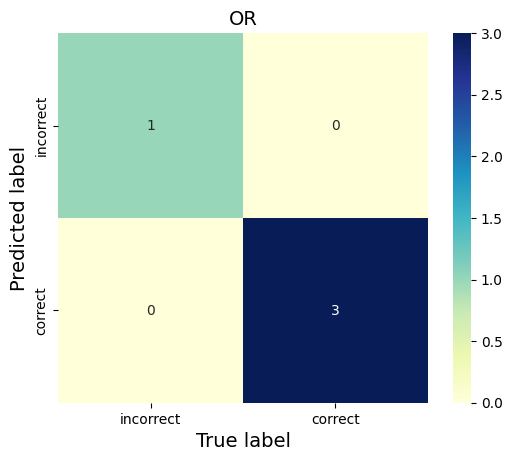

<Figure size 2000x1400 with 0 Axes>

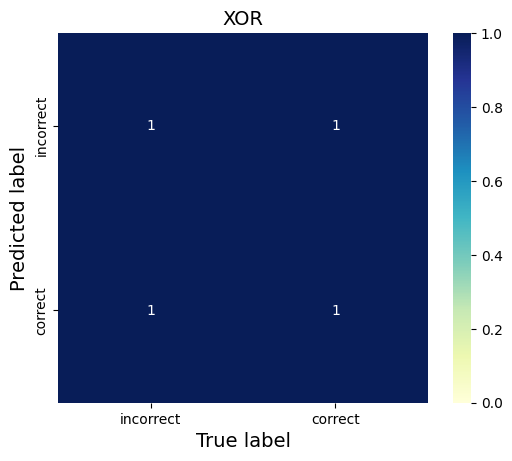

In [69]:
for op, f in dict.items():
    X = tensor(X_raw, dtype=torch.float)
    Y = f(X)
    p = MyPerceptron(2, lr=0.3)
    p.fit(X, Y, n_epochs=6)
    Y_p = p.predict(X)

    plot_confusion_matrix(Y, Y_p, op, cat_names)

### Testing the Sklearn perceptron on AND, OR and XOR

<Figure size 2000x1400 with 0 Axes>

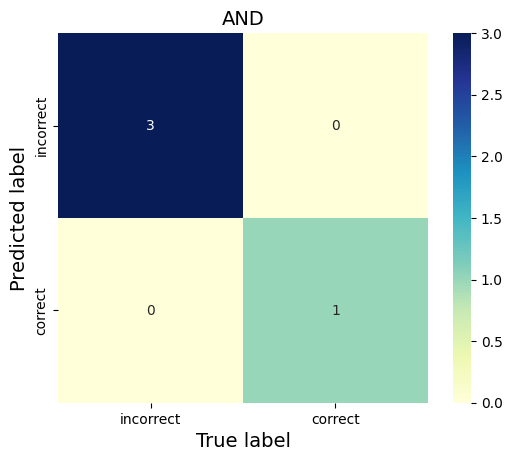

<Figure size 2000x1400 with 0 Axes>

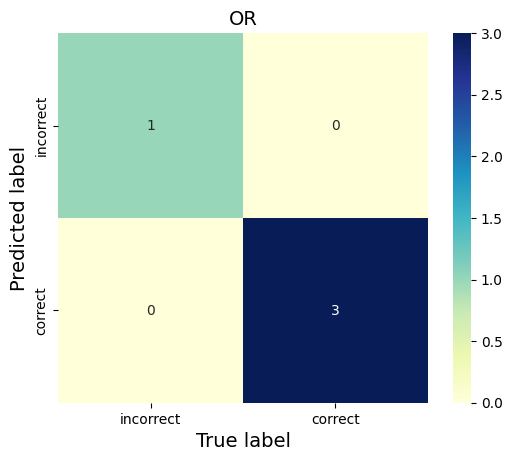

<Figure size 2000x1400 with 0 Axes>

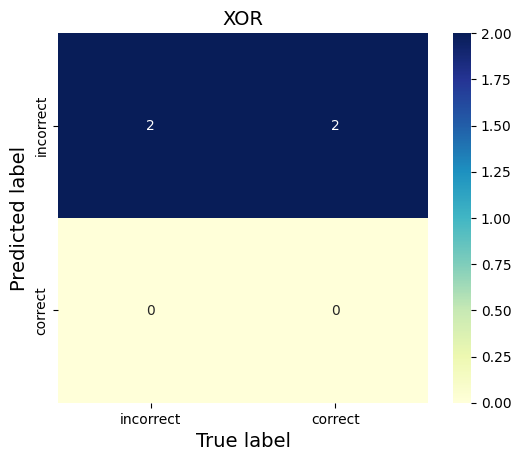

In [70]:
for op, f in dict.items():
    X = tensor(X_raw, dtype=torch.float)
    Y = f(X).flatten()
    p = SkPerceptron()
    p.fit(X, Y)
    Y_p = p.predict(X)

    plot_confusion_matrix(Y, Y_p, op, cat_names)

### Comparing all NN variants on AND, OR and XOR


 AND
Errors in regressor251: 0
Errors in classifier251: 0
Errors in classifier252: 0
Errors in classifier2XX2: 0

 OR
Errors in regressor251: 0
Errors in classifier251: 0
Errors in classifier252: 0
Errors in classifier2XX2: 1

 XOR
Errors in regressor251: 0
Errors in classifier251: 0
Errors in classifier252: 0
Errors in classifier2XX2: 1


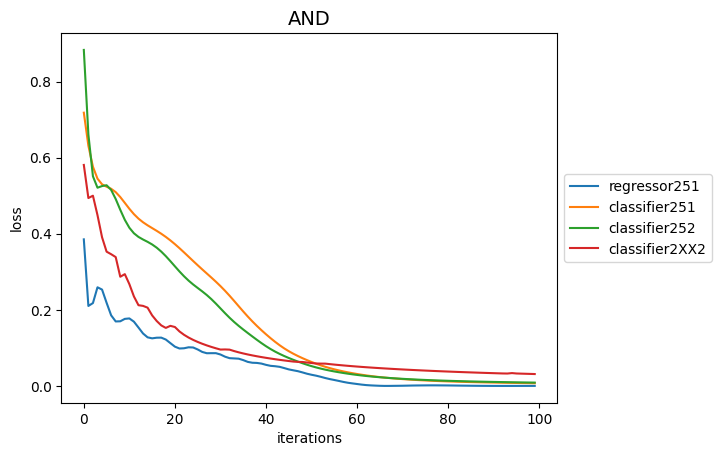

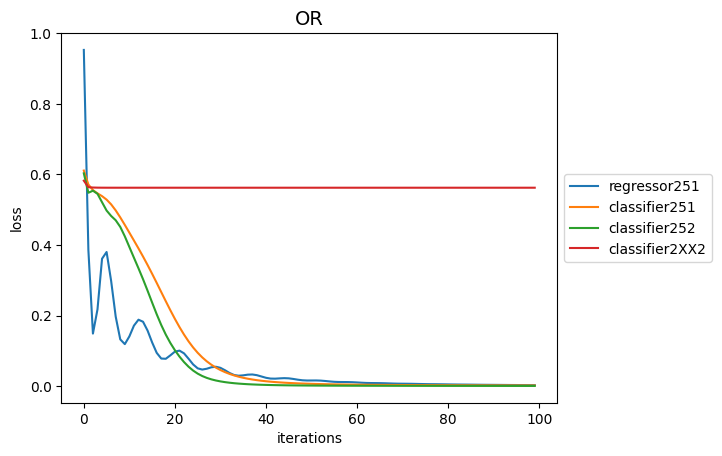

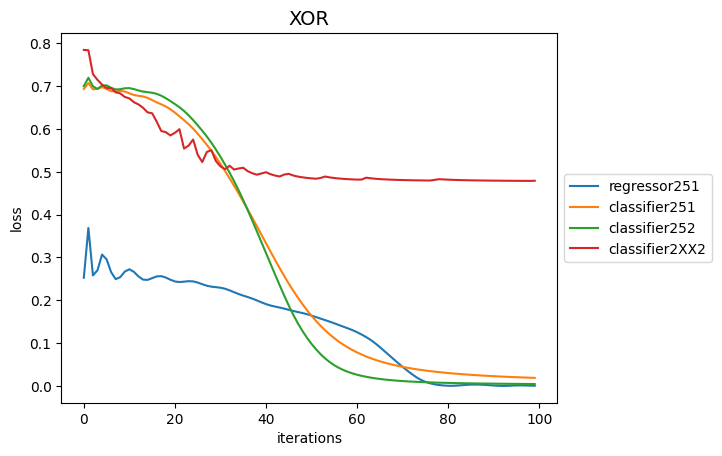

In [71]:
lr = 1e-1
n_epochs = 100

for op, f in dict.items():
    print('\n', op)
    plt.figure()
    for v in variants:
        X = tensor(X_raw, requires_grad=True, dtype=torch.float32)
        Y = f(X.detach())
        clf = v(lr)
        protocol = clf.fit(X, Y, n_epochs)
        plot_loss(protocol, op, v.__name__)
        Y_p = clf.predict(X)
        diff = Y_p - Y.view(-1, 1)
        print(f'Errors in {v.__name__ :10}: {len(diff[diff != 0])}')

### Comparing all NN variants on planes, circles and squares


 plane0
Errors (train) in regressor251: 5
Errors (test) in regressor251: 1
Errors (train) in classifier251: 2
Errors (test) in classifier251: 2
Errors (train) in classifier252: 0
Errors (test) in classifier252: 1
Errors (train) in classifier2XX2: 5
Errors (test) in classifier2XX2: 3

 plane1
Errors (train) in regressor251: 1
Errors (test) in regressor251: 1
Errors (train) in classifier251: 1
Errors (test) in classifier251: 0
Errors (train) in classifier252: 1
Errors (test) in classifier252: 2
Errors (train) in classifier2XX2: 1
Errors (test) in classifier2XX2: 0

 plane2
Errors (train) in regressor251: 0
Errors (test) in regressor251: 0
Errors (train) in classifier251: 0
Errors (test) in classifier251: 1
Errors (train) in classifier252: 0
Errors (test) in classifier252: 1
Errors (train) in classifier2XX2: 8
Errors (test) in classifier2XX2: 3

 circle
Errors (train) in regressor251: 5
Errors (test) in regressor251: 12
Errors (train) in classifier251: 5
Errors (test) in classifier251: 1

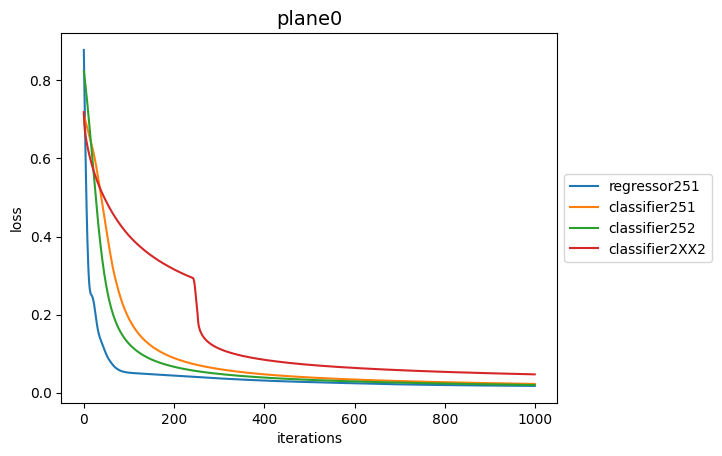

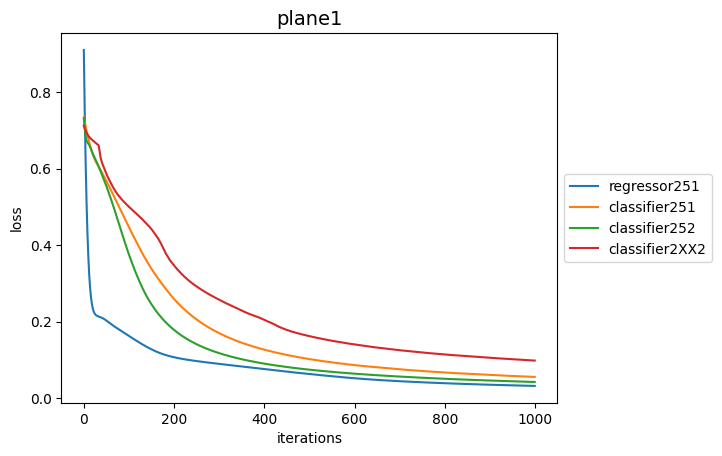

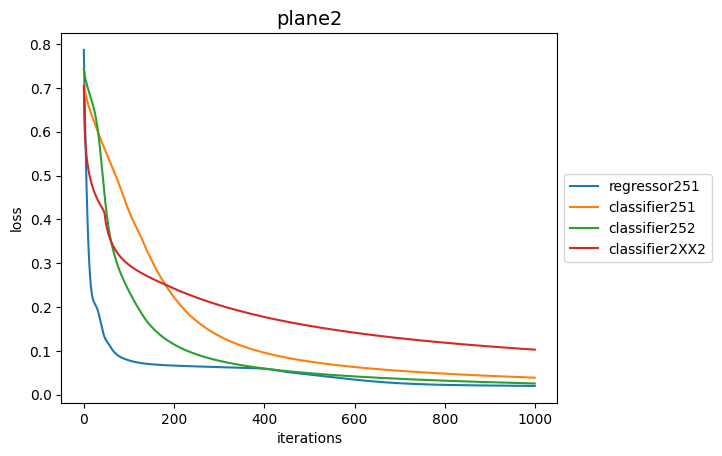

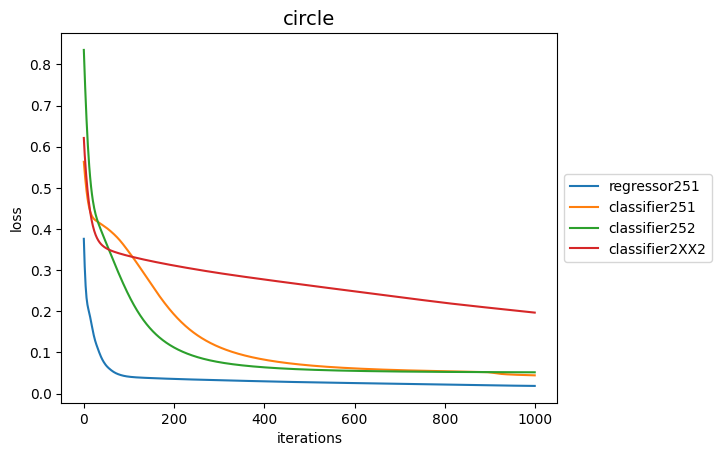

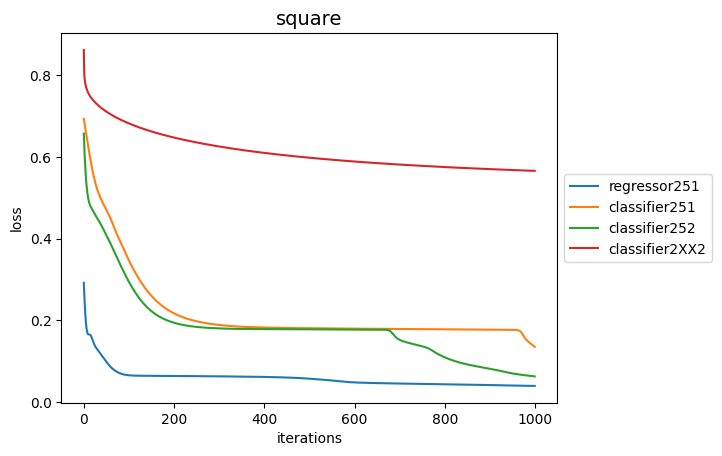

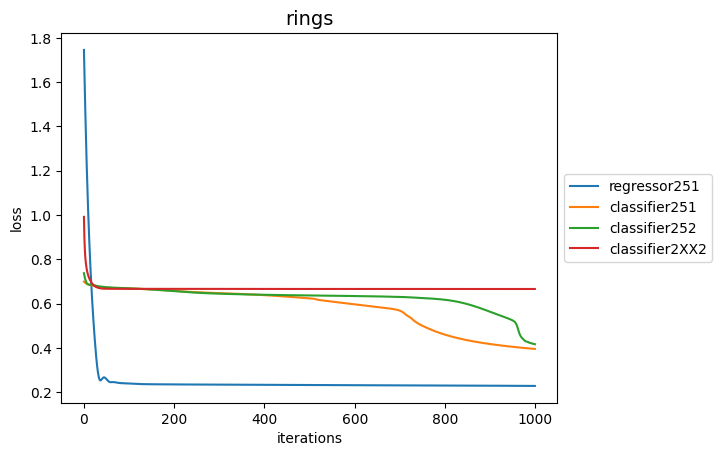

In [72]:
p0 = plane([-1, 1], 0)  # -x0 + x1 = 0
p1 = plane([1, 1], -10)  # x0 + x1 = 10
p2 = plane([0, 1], -5)  # x1 = 5
c = circle(5)  # radius = 5
s = square(5)  # side length = 10
r = rings(3)
dict1 = {'plane0': p0, 'plane1': p1, 'plane2': p2, 'circle': c, 'square': s, 'rings': r}

X = torch.rand((300, 2)) * 10
lr = 1e-2
n_epochs = 1000

for op, f in dict1.items():
    print('\n', op)
    plt.figure()
    for v in variants:
        X.requires_grad_()
        Y = f(X.detach())
        clf = v(lr)
        protocol = clf.fit(X, Y, n_epochs)
        plot_loss(protocol, op, v.__name__)
        Y_p = clf.predict(X)
        diff = Y_p - Y.view(-1, 1)
        print(f'Errors (train) in {v.__name__ :10}: {len(diff[diff != 0])}')

        X_t = torch.rand((300, 2)) * 10
        Y_t = f(X_t)
        Y_pt = clf.predict(X_t)
        diff = Y_pt - Y_t.view(-1, 1)
        print(f'Errors (test) in {v.__name__ :10}: {len(diff[diff != 0])}')

### Testing the Sklearn perceptron on various functions

<Figure size 2000x1400 with 0 Axes>

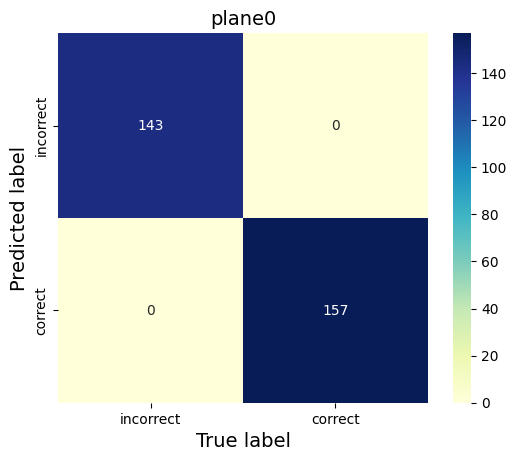

<Figure size 2000x1400 with 0 Axes>

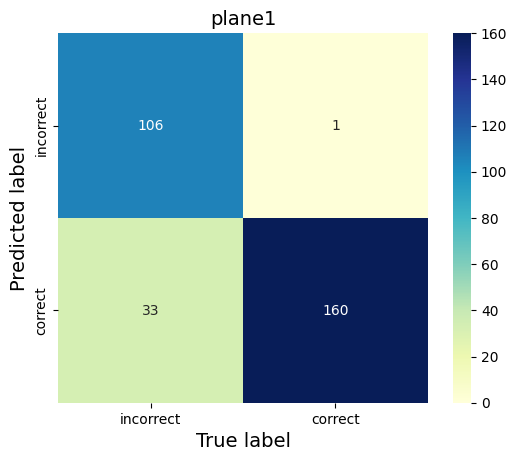

<Figure size 2000x1400 with 0 Axes>

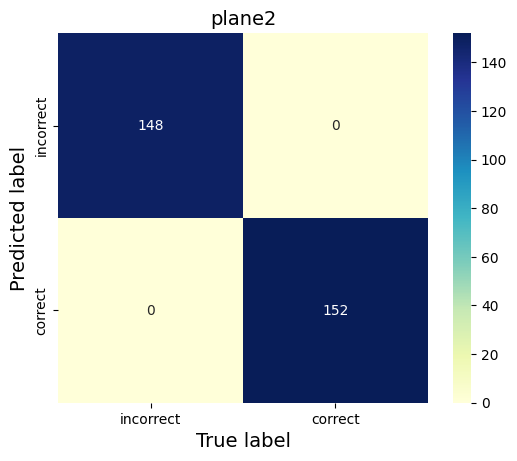

<Figure size 2000x1400 with 0 Axes>

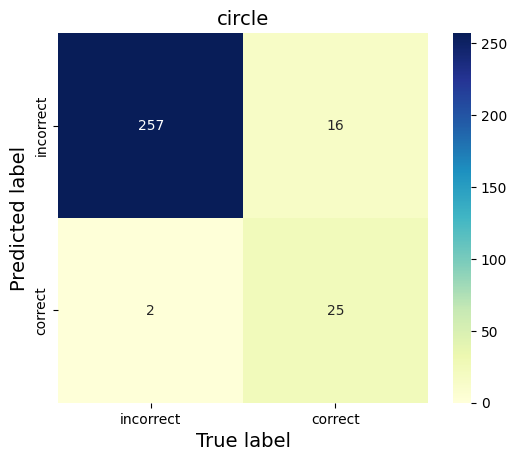

<Figure size 2000x1400 with 0 Axes>

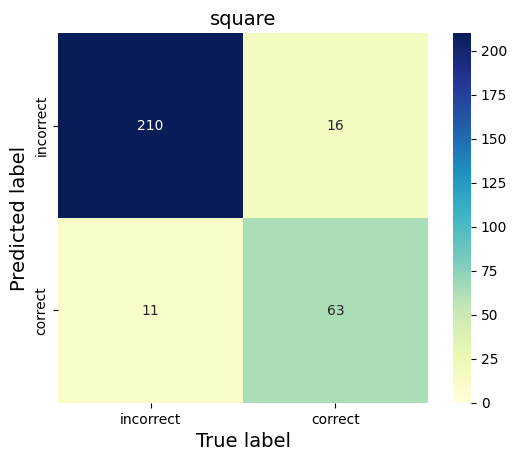

<Figure size 2000x1400 with 0 Axes>

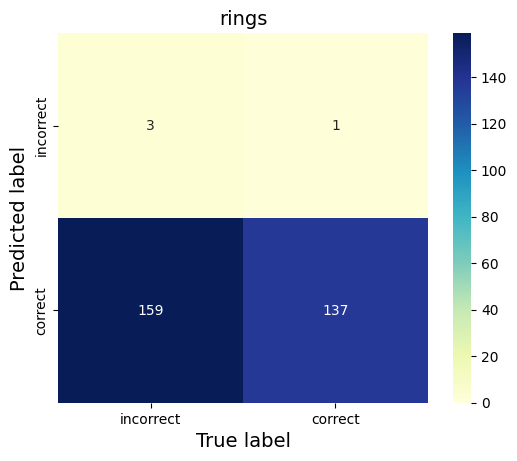

In [73]:
for op, f in dict1.items():
    X_test = torch.rand((300, 2)) * 10
    Y = f(X_test).flatten()
    p = SkPerceptron()
    p.fit(X_test, Y)
    Y_p = p.predict(X_test)
    plot_confusion_matrix(Y, Y_p, op, cat_names)